### Code import place

In [26]:
%reset -f
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import numpy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import time
import pandas as pd
import os.path
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_squared_log_error
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image, display
import tensorflow
os.environ['PATH'] += ';C:\\Program Files\\Graphviz\\bin'
import graphviz
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout,     BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, fbeta_score, make_scorer
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, precision_score, precision_recall_curve, average_precision_score
from keras.layers import Input, Dense, Add, merge, TimeDistributed
from keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer
# !pip install talos
import talos
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [27]:
environment_variables = dir()

In [28]:
# Input parameters
TRAINING_FILES = ["../data/original/training_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_training_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv"]
EVALUATION_FILES = ["../data/original/evaluation_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_evaluation_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv"]


# On difference_preprocessed_evaluation_dataset results recieved are a lot better,
#  but we are fitting with pipelines and other parameters. So we are setting the original splitted train test dataset.
FILE_N = 0 
INPUT_TRAINING_FILE = TRAINING_FILES[FILE_N] 
INPUT_EVALUATION_FILE = EVALUATION_FILES[FILE_N]

# File outputing parameters
METHOD_NAME = "keras_tensorflow_sequential"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL_FOLDER = f"../data/models/keras_models"
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_keras_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"
OUTPUT_MODEL_ARCHITECTURE_RESULTS = f"../img/{METHOD_NAME}_model_{TIMESTAMP}.png"

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 5

# Constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

# Preprocessing parameters
HYPER_PARAMETER_K_FEATURES = list(range(30, 90, 10))
HYPER_PARAMETER_SCORE_FUNC = [chi2, f_classif]

# Hyper parameter alternatives for Keras Tensorflow model
HYPER_PARAMETER_CLASIFIER_OPTIMIZERS = ['rmsprop','adam','adagrad']
HYPER_PARAMETER_EPOCHS = [10,20,40,60]
HYPER_PARAMETER_DROPUT = [0,0.1,0.2,0.3]
HYPER_PARAMETER_LAYERS_N = list(range(20,90,10))
HYPER_PARAMETER_BATCH_NUMBER = list(range(20,160,30))
HYPER_PARAMETER_KERNEL_INITIALIZER = ['glorot_uniform','normal','uniform']
HYPER_PARAMETER_CLASIFIER_METRICS = ['accuracy']

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_BETA = 2
HYPER_PARAMETER_OPTIMIZATION_CV = 5
CROSS_VALIDATION_CV = 5

In [29]:
# Reading training dataset
training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
# Setting and removing the labels from Training features.
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

# Reading validation dataset
evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
# Setting and removing the labels from Training features.
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

# Describing dataset for data overview
training_dataset.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,...,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.0,5455.000000
mean,0.032264,0.505525,0.559258,0.554044,0.608035,0.608015,0.998701,0.797142,0.809031,0.303653,...,0.808241,1.940972e+07,0.623871,0.608033,0.840590,0.280185,0.027601,0.565455,1.0,0.047765
std,0.176717,0.059556,0.063889,0.060242,0.017631,0.017613,0.014543,0.014377,0.015197,0.012469,...,0.038275,3.820503e+08,0.013361,0.017631,0.009228,0.010323,0.017393,0.009062,0.0,0.050139
min,0.000000,0.000000,0.006923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.224792,1.015558e-04,0.000000,0.000000,0.344652,0.000000,0.000000,0.172065,1.0,0.000000
25%,0.000000,0.476868,0.535652,0.527651,0.600437,0.600427,0.998970,0.797387,0.809312,0.303467,...,0.796867,9.065413e-04,0.623641,0.600437,0.840121,0.276939,0.026791,0.565158,1.0,0.024593
50%,0.000000,0.503096,0.560238,0.552492,0.605933,0.605904,0.999023,0.797463,0.809376,0.303525,...,0.810872,2.102861e-03,0.623882,0.605932,0.841195,0.278762,0.026808,0.565253,1.0,0.033914
75%,0.000000,0.535709,0.589348,0.584533,0.614019,0.614001,0.999096,0.797580,0.809470,0.303586,...,0.826527,5.347827e-03,0.624168,0.614017,0.842360,0.281407,0.026910,0.565717,1.0,0.052995
max,1.000000,0.971530,1.000000,1.000000,1.000000,1.000000,0.999778,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,0.652347,1.000000,0.736985,1.0,1.000000


### Experiments with creating more complex functionall model for Keras Tensorflow classifier

- This model was used for experimenting various Keras.Functionall model types with pipelines.
- It is left for further experiments.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 95)]         0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 95)           9120        input_3[0][0]                    
__________________________________________________________________________________________________
dense_relu2a (BatchNormalizatio (None, 95)           380         dense_15[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 95)           0           dense_relu2a[0][0]               
____________________________________________________________________________________________

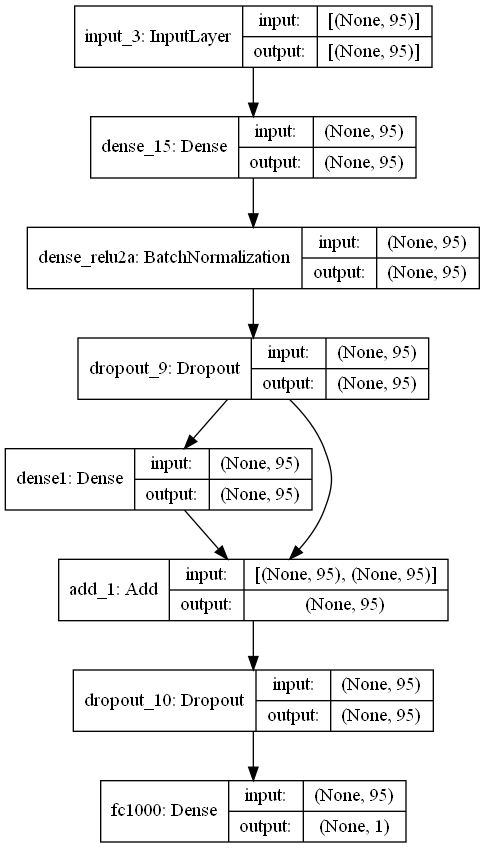

<class 'keras.engine.functional.Functional'>


In [30]:

def keras_model_for_sklearn(optimizer='adam',
                    loss = 'binary_crossentropy', 
                    kernel_initializer='glorot_uniform', 
                    dropout=0.2, layers_n  = 95,
                    n_activator = 'relu',
                    neurons = 213 ,
                    n_out = 1,
                    f_activator = 'relu',
                    batch_norm = True,
                    metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]
                  ):
        
    # Input layer is required to define calculations needed for later model dimentions.
    input =tensorflow.keras.layers.Input(shape=(layers_n,))
    # Creating 1st dense layer consisting of n dimentions,
    # it requires to refer to the input layer. So it 
    # could continue shape and flow of model
    output1 =tensorflow.keras.layers.Dense(layers_n, input_shape=(layers_n,), activation=n_activator)(input)

    # Inclusion of batch normalisation.
    # It is desinged to standardize inputs to a layer.
    # Meant to increase the performance of training process.
    if batch_norm:
        output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)

    # Regularization technique - called Droput layer randomly chooses the neurons and sets the inputs to 0. With a frequency of x% 
    # it is scaled from [0, 0.1, ... , 0.9, 1]
    # Dropout will only be used during the training.
    # It will not affect the layers during validation.
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    dense_name_base = "dense"

    # Defining hidden dense layer.
    shortcut1 =tensorflow.keras.layers.Dense(layers_n, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '1')(output1)
    # Creating shortcut function
    output1 = Add()([output1, shortcut1])

    # Finalizing our pool
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output1)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)

    # Plot model information
    plot_= True
    if plot_:
        # SAving model diagram in specified location
        time_tmp = time.strftime("%d_%m_%Y-%H_%M_%S")
        loc_tmp = f"../img/{METHOD_NAME}_keras_functional_shortcut_model_{time_tmp}.png"
        plot_model(model, to_file=loc_tmp, show_shapes=True, show_layer_names=True)
        im = cv2.imread(loc_tmp, 0)
        model.summary()
        display(Image(filename=loc_tmp))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model
print(type(keras_model_for_sklearn()))# <class 'keras.engine.functional.Functional'>


### Creating Keras model 
- Here we create keras model
- It is being created using keras Sequential model.

In [31]:
plot_tf = True    
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam', kernel_initializer='normal', dropout=0.2, layers_n = 64, metrics="accuracy", batchn = True, hidden_layer_sizes = [20,90], plot_tf = False):
    model = Sequential()
    model.add(Dense(layers_n,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    if batchn:
        model.add(BatchNormalization())
    
    model.add(Dense(1,activation='relu',kernel_initializer=kernel_initializer))
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[metrics])
    return model

param_grid = {
    "selection__k": HYPER_PARAMETER_K_FEATURES,
    "selection__score_func": HYPER_PARAMETER_SCORE_FUNC,
    'clf__optimizer':HYPER_PARAMETER_CLASIFIER_OPTIMIZERS,
    'clf__epochs':HYPER_PARAMETER_EPOCHS,
    'clf__dropout':HYPER_PARAMETER_DROPUT,
    'clf__layers_n' : HYPER_PARAMETER_LAYERS_N,
    'clf__batchn' : HYPER_PARAMETER_BATCH_NUMBER,
    'clf__kernel_initializer':HYPER_PARAMETER_KERNEL_INITIALIZER,
    'clf__metrics':HYPER_PARAMETER_CLASIFIER_METRICS,
}

# Best alternative:
param_grid = {
    'clf__optimizer':['adam'],
    'clf__epochs':[10],
    'clf__dropout':[0.2],
    'clf__layers_n' : [64],
    'clf__kernel_initializer':['uniform'],
    'clf__metrics':['accuracy'],
    "selection__k": [30],
    "selection__score_func": [chi2],
}

# Using keras regresor for our custom model.
# Keras regresor is used to fit our model into the pipeline.
clf = KerasRegressor(build_fn=create_model,verbose=3)

# Definng standart scalers
scaler = StandardScaler()

# Oversample data with SMOTE.
# Taking this step before approaching pipeline.
smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_SEED)
X_train, y_train = training_features,training_targets
X_train, y_train = smote.fit_resample(training_features,training_targets)

# Min max scaler definition 
min_max_scaler =  MinMaxScaler()

# Feature selection 
feature_selection = SelectKBest()

# Setting the keras model pipeline
pipeline = Pipeline([
    ('preprocess',scaler),
    ("min_max_scaler", min_max_scaler),
    ("selection", feature_selection),
    ('clf',clf)
])


def custom_scorer(y_true, y_pred):
    # We define confidence 0 so classification could be comparing the scores, if the confidence is more then 0 it selects the company as bancrupt.
    # In the end we select 50% confidence and it ouputs the best results.
    confidence = 0
    # Binary_cross entropy displays confidence of true value. 
    y_pred = (np.where(y_pred > confidence, 1, 0))    
    print(confusion_matrix(y_true, y_pred))

    # Rerutning defined custom fbeta scorer function that put emphasis on recall
    return fbeta_score(y_true, y_pred, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

# Pushing the pipeline to the cross validation grid search
grid = GridSearchCV(pipeline, 
                    cv=CROSS_VALIDATION_CV,
                    param_grid=param_grid
                    , verbose = 3 
                    , scoring=make_scorer(custom_scorer)
                    )
# Fitting the gri
grid.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[[ 669 1443]
 [   0    0]]
[CV 1/5] END clf__dropout=0.2, clf__epochs=10, clf__kernel_initializer=uniform, clf__layers_n=64, clf__metrics=accuracy, clf__optimizer=adam, selection__k=30, selection__score_func=<function chi2 at 0x000001FB9B471280>;, score=0.000 total time=  10.2s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[[ 828 1284]
 [   0    0]]
[CV 2/5] END clf__dropout=0.2, clf__epochs=10, clf__kernel_initializer=uniform, clf__layers_n=64, clf__metrics=accuracy, clf__optimizer=adam, selection__k=30, selection__score_func=<function chi2 at 0x000001FB9B471280>;, score=0.000 total time=   8.0s
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[[ 186  869]
 [   0 1057]]
[CV 3/5] END clf__dropo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess', StandardScaler()),
                                       ('min_max_scaler', MinMaxScaler()),
                                       ('selection', SelectKBest()),
                                       ('clf',
                                        <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001FBA65DC940>)]),
             param_grid={'clf__dropout': [0.2], 'clf__epochs': [10],
                         'clf__kernel_initializer': ['uniform'],
                         'clf__layers_n': [64], 'clf__metrics': ['accuracy'],
                         'clf__optimizer': ['adam'], 'selection__k': [30],
                         'selection__score_func': [<function chi2 at 0x000001FB9B471280>]},
             scoring=make_scorer(custom_scorer), verbose=3)

### Best model parameters
- F-Beta (2) score = 0.571227

In [32]:
print("Best model: F-beta Score = %f, with parameters %s" % (grid.best_score_, grid.best_params_))

Best model: Acc. Score = 0.571227, with parameters {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x000001FB9B471280>}


### How the model looks like?

330/330 [==============================] - 2s 3ms/step - loss: 2.1495 - accuracy: 0.5917
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                1984      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 2,305
Trainable params: 2,177
Non-trainable params: 128
_________________________________________________________________


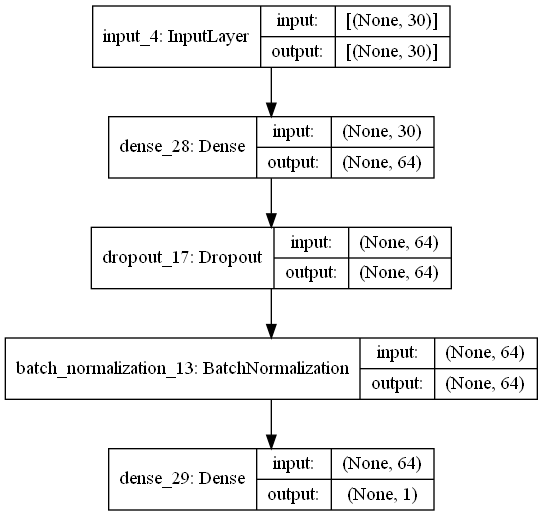

In [33]:
plot_tf = True
if plot_tf:
        feature_selection = SelectKBest(grid.best_params_['selection__score_func'],  k=grid.best_params_['selection__k'])  
        X_train_ = feature_selection.fit_transform(X_train,y_train)
        model_from_grid =  create_model(optimizer=grid.best_params_['clf__optimizer'],
            dropout=grid.best_params_['clf__dropout'],
            layers_n=grid.best_params_['clf__layers_n'],
            kernel_initializer=grid.best_params_['clf__kernel_initializer'],
            metrics =grid.best_params_['clf__metrics'],
        plot_tf=False)
        
        model_from_grid.fit(X_train_, y_train)
        input_layer = Input(batch_shape=model_from_grid.layers[0].input_shape)
        prev_layer = input_layer
        for layer in model_from_grid.layers:
            layer._inbound_nodes = []
            prev_layer = layer(prev_layer)

        model_ = models.Model([input_layer], [prev_layer])
        plot_model(model_, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model_.compile(loss='binary_crossentropy',optimizer=grid.best_params_['clf__optimizer'], metrics=grid.best_params_['clf__metrics'])
        model_.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))
        plot_tf = False

## Reports of classification results of single (binary cross entropy) class.

- In this section we are simply itterationg the predictions using different confidence values. 
- the reason for this just to see what is the models treshold for predicting the best score based on validation results.


In [39]:
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

def output_parameters(confidence, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = False ):

    # Use all training data to calculate confusion matrix for training data
    training_estimates_ = grid.predict(training_features)
    training_estimates = np.where(training_estimates_ > confidence, 1, 0)

    training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
    training_confusion_matrix = confusion_matrix(training_targets, training_estimates)

    # Use model to estimate manually labeled evaluation Tweets
    evaluation_estimates_ = grid.predict(evaluation_features)

    evaluation_estimates = np.where(evaluation_estimates_ > confidence, 1, 0)

    evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
    evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)


    if max_acc <= evaluation_accuracy:
        max_acc = evaluation_accuracy
        best_conf = confidence

    print(f"Confidence {confidence}")
    if log:
        print(training_estimates_)
        print("\n_________________________________________________")
        print(training_estimates)
        print(training_confusion_matrix)
        print(evaluation_estimates_[:5])
        print(evaluation_estimates[:5])
        print(evaluation_confusion_matrix)

    print(f"Balanced training. acc: {training_accuracy}")

    print(f"Balanced eval. acc: {evaluation_accuracy}")

    # summarize results

    if log:
        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        params = grid.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))

        print("Training evaluation")

        y_pred_train_ = grid.predict(training_features)
        print(y_pred_train_)
        y_pred_train = np.where(y_pred_train_ > confidence, 1, 0)
        print(classification_report(training_targets, y_pred_train))
        train_conf_matrix = confusion_matrix(training_targets, y_pred_train)

        print("Validation/evaluation")
        y_pred_test_ = grid.predict(evaluation_features) # prediction on our test set

        print(y_pred_test_)
        y_pred_test = np.where(y_pred_test_ > confidence, 1, 0)

        print(classification_report(evaluation_targets, y_pred_test))
        test_conf_matrix = confusion_matrix(evaluation_targets, y_pred_test)
        print(test_conf_matrix)
        return max_acc, best_conf, training_confusion_matrix, evaluation_confusion_matrix
    else:
        return max_acc, best_conf

confidences =  numpy.arange(0, 1,0.02)
max_acc = 0
best_conf = 0
log = False

for confidence in confidences:
    max_acc,best_conf = output_parameters(confidence, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = False )

print(f"max_acc {max_acc}, best_conf{best_conf}")

Confidence 0.0
Balanced training. acc: 0.7831039366959995
Balanced eval. acc: 0.7541666666666667
Confidence 0.02
Balanced training. acc: 0.7949433002118169
Balanced eval. acc: 0.7655303030303031
Confidence 0.04
Balanced training. acc: 0.8074456680845201
Balanced eval. acc: 0.7768939393939394
Confidence 0.06
Balanced training. acc: 0.8178643079784395
Balanced eval. acc: 0.7897727272727273
Confidence 0.08
Balanced training. acc: 0.8293248118617507
Balanced eval. acc: 0.7787878787878788
Confidence 0.1
Balanced training. acc: 0.8368078277566343
Balanced eval. acc: 0.7912878787878788
Confidence 0.12
Balanced training. acc: 0.846942322926174
Balanced eval. acc: 0.8011363636363636
Confidence 0.14
Balanced training. acc: 0.8562243839225748
Balanced eval. acc: 0.7992424242424243
Confidence 0.16
Balanced training. acc: 0.8637068616645714
Balanced eval. acc: 0.8087121212121212
Confidence 0.18
Balanced training. acc: 0.8728942077528457
Balanced eval. acc: 0.8174242424242424
Confidence 0.2
Balanced

- Concluding the measurments using different confidence.
    - The recieved best confidence treshold was ~0.5.
    - so we can say that the model predicts company as non bancrupt if the company treshold is < 50%
    - if confidence >= 50%, the model will predict the values as bancrupt.
    - With 0.5 treshold balanced accuracy score is 84%

In [41]:
confidence = best_conf
max_acc,best_conf, training_confusion_matrix,evaluation_confusion_matrix = output_parameters(best_conf, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = True )

training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)
display(training_confusion_matrix)
display(evaluation_confusion_matrix)

Confidence 0.4
[0.90298796 0.16610068 0.03149197 ... 0.7227201  0.83098745 0.4476959 ]

_________________________________________________
[1 0 0 ... 1 1 1]
[[4725  554]
 [  29  147]]
[0.         0.48190486 0.10423457 0.         0.        ]
[0 1 0 0 0]
[[1157  163]
 [   8   36]]
Balanced training. acc: 0.8651415772615336
Balanced eval. acc: 0.8473484848484849
Best: 0.571227 using {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x000001FB9B471280>}
0.571227 (0.469194) with: {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x000001FB9B471280>}
Training evaluation
[0.90298796 0.16610068 0.03149197 ... 0.7227201  0.83098745 0.4476959 ]
              precision 

'True operational=4725, True bankrupt=147, False operational=554, False bankrupt=29'

'True operational=1157, True bankrupt=36, False operational=163, False bankrupt=8'

### Confusion matrix

Test dataset conf matrix

- [[1157  163]
- [   8   36]]

Validation Confusion Matrix

- [[4725  554]
- [  29  147]]

### Ouptuting text clasification results.

In [42]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
print(results_string)

# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)

CROSS_VALIDATION_CV: 5
EVALUATION_FILES: ['../data/original/evaluation_dataset.csv', '..\\data\\preprocessed\\difference_preprocessed_evaluation_dataset.csv', '..\\data\\preprocessed\\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv']
FILE_N: 0
HYPER_PARAMETER_BATCH_NUMBER: [20, 50, 80, 110, 140]
HYPER_PARAMETER_CLASIFIER_METRICS: ['accuracy']
HYPER_PARAMETER_CLASIFIER_OPTIMIZERS: ['rmsprop', 'adam', 'adagrad']
HYPER_PARAMETER_DROPUT: [0, 0.1, 0.2, 0.3]
HYPER_PARAMETER_EPOCHS: [10, 20, 40, 60]
HYPER_PARAMETER_KERNEL_INITIALIZER: ['glorot_uniform', 'normal', 'uniform']
HYPER_PARAMETER_K_FEATURES: [30, 40, 50, 60, 70, 80]
HYPER_PARAMETER_LAYERS_N: [20, 30, 40, 50, 60, 70, 80]
HYPER_PARAMETER_OPTIMIZATION_BETA: 2
HYPER_PARAMETER_OPTIMIZATION_CV: 5
HYPER_PARAMETER_OPTIMIZATION_SCORING: accuracy
HYPER_PARAMETER_SCORE_FUNC: [<function chi2 at 0x000001FB9B471280>, <function f_classif at 0x000001FB9B471160>]
INPUT_EVALUATION_FILE: ../data/original/evaluation_dataset.csv
INPUT_T

In [37]:
# !pip install import weakref

import pickle
with open(OUTPUT_MODEL, "wb") as handle:
    pickle.dump(grid, OUTPUT_MODEL)


TypeError: file must have a 'write' attribute